In [1]:
# Model calling and intial setup
import os
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_openai import AzureChatOpenAI
from dotenv import load_dotenv
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser 
import warnings
warnings.filterwarnings("ignore") 

load_dotenv()
# Load env
OPENROUTER_API_KEY = os.getenv("OPENROUTER_API_KEY")
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
AZURE_BASE_URL = os.getenv("AZURE_BASE_URL")
AZURE_OPENAI_API_KEY = os.getenv("AZURE_OPENAI_API_KEY")
AZURE_CHAT_DEPLIOYMENT_NAME = os.getenv("AZURE_CHAT_DEPLIOYMENT_NAME")

parser = StrOutputParser()

llm_gemini = ChatGoogleGenerativeAI(model="gemini-2.0-flash" , api_key= GOOGLE_API_KEY)

llm_openai = AzureChatOpenAI(
    model="gpt-4o-mini",                         
    deployment_name=AZURE_CHAT_DEPLIOYMENT_NAME ,  # deployment name in Azure
    api_key=AZURE_OPENAI_API_KEY,
    azure_endpoint=AZURE_BASE_URL,
    api_version="2024-02-01"
) 
llm_openai.invoke("What are your creater, also what type of LLM are you").content
# llm_gemini.invoke("who is father of india").content

c:\Users\singh\Let's Gooooo\Langgraph\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


'I was created by OpenAI, an organization focused on advancing artificial intelligence in a safe and beneficial manner. I am a large language model (LLM) known as GPT-3 (Generative Pre-trained Transformer 3). My primary function is to understand and generate human-like text based on the input I receive. If you have any questions or need assistance, feel free to ask!'

### Persistance
- it is refer to ability to save and restore the state of a workflow overtime in langgraph

- Not only store final values, but store all the values, without using a reducer fucntion

- This add consistecy and reliability

- Add fault Tolrence

### Checkpointers

- persistance is implemented using checkpointers

- At each superstep, we save state in either RAM or in DB

### Threads

- what about diff users using the application, as for each invoke fucntion i'm saving all the 

- for each unique user an unique chat, we give a new thread id


In [7]:
from langgraph.graph import StateGraph , START , END
from typing import TypedDict
from langgraph.checkpoint.memory import InMemorySaver

class JokeState(TypedDict):
    topic : str
    joke : str
    explanation : str
    
def get_joke(state:JokeState)->JokeState:
    promt = PromptTemplate(
        template="You're a Moderm comedian, based on the topic give a joke that is fresh and new, and more imprtanlt funny, Topic : \n{topic}",
        input_variables=['topic']
    )
    
    joke_create_chain = promt | llm_openai | parser
    joke = joke_create_chain.invoke({"topic" : state['topic']})
    state['joke'] = joke
    return state

def get_explnation(state:JokeState)->JokeState:
    promt = PromptTemplate(
        template="You're a Moderm comedian critic, based on the joke given to you provide a explation to to joke, what is the primise hook and punchline in the joke, Joke: \n{joke}",
        input_variables=['joke']
    )
    
    joke_explain_chain = promt | llm_openai | parser
    explnation = joke_explain_chain.invoke({"joke" : state['joke']})
    state['explanation'] = explnation
    return state

# Create Graph
graph = StateGraph(JokeState)

graph.add_node("create_joke" , get_joke)
graph.add_node("explain_joke" , get_explnation)

# create Edges
graph.add_edge(START , "create_joke")
graph.add_edge("create_joke" , "explain_joke")
graph.add_edge('explain_joke' , END)

# Create checkpointers
checkpinter = InMemorySaver()

joke_workflow = graph.compile(checkpointer=checkpinter)

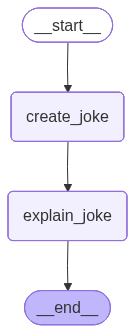

In [8]:
from IPython.display import Image
Image(joke_workflow.get_graph().draw_mermaid_png())

In [10]:
intial_state = {"topic" : "a schhol in india"}
config = {"configurable" : {"thread_id" : "1"}}

final_state = joke_workflow.invoke(intial_state , config= config)
final_state

{'topic': 'a schhol in india',
 'joke': 'Sure, here’s a fresh take on that topic:\n\nYou know you\'re in a school in India when the principal\'s idea of encouraging creativity is telling kids, "Draw a poster about the dangers of social media"… and half the class comes in with a colorful meme of him on Instagram! ',
 'explanation': 'Here\'s a breakdown of the joke:\n\n### Explanation\nThe humor in this joke centers around the idea of creativity in the context of educational environments, particularly in a school in India. \n\n### Premise\nThe premise sets the scene: it introduces a typical scenario in a school where the principal is trying to encourage students to be creative. However, the specific assignment—creating a poster about the dangers of social media—implies a serious tone regarding the potential pitfalls of social media platforms.\n\n### Hook\nThe hook lies in the irony of the situation. Instead of the students taking the principal\'s assignment seriously, they interpret it i

In [12]:
joke_workflow.get_state(config=config)

StateSnapshot(values={'topic': 'a schhol in india', 'joke': 'Sure, here’s a fresh take on that topic:\n\nYou know you\'re in a school in India when the principal\'s idea of encouraging creativity is telling kids, "Draw a poster about the dangers of social media"… and half the class comes in with a colorful meme of him on Instagram! ', 'explanation': 'Here\'s a breakdown of the joke:\n\n### Explanation\nThe humor in this joke centers around the idea of creativity in the context of educational environments, particularly in a school in India. \n\n### Premise\nThe premise sets the scene: it introduces a typical scenario in a school where the principal is trying to encourage students to be creative. However, the specific assignment—creating a poster about the dangers of social media—implies a serious tone regarding the potential pitfalls of social media platforms.\n\n### Hook\nThe hook lies in the irony of the situation. Instead of the students taking the principal\'s assignment seriously, 

In [13]:
list(joke_workflow.get_state_history(config=config))

[StateSnapshot(values={'topic': 'a schhol in india', 'joke': 'Sure, here’s a fresh take on that topic:\n\nYou know you\'re in a school in India when the principal\'s idea of encouraging creativity is telling kids, "Draw a poster about the dangers of social media"… and half the class comes in with a colorful meme of him on Instagram! ', 'explanation': 'Here\'s a breakdown of the joke:\n\n### Explanation\nThe humor in this joke centers around the idea of creativity in the context of educational environments, particularly in a school in India. \n\n### Premise\nThe premise sets the scene: it introduces a typical scenario in a school where the principal is trying to encourage students to be creative. However, the specific assignment—creating a poster about the dangers of social media—implies a serious tone regarding the potential pitfalls of social media platforms.\n\n### Hook\nThe hook lies in the irony of the situation. Instead of the students taking the principal\'s assignment seriously,

## Benifits of persistance

1) Short term memory : application like chatbots
2) Fault Tolrence : instead of providing a intial state, if yoy pass "None" for a thread_id. it will resume and finish the previously crashed workflow
3) Adding Human in the loop 
4) Time travel : Can do debugging and go in the past 

### Time travel 


In [ ]:
config1 = {"configurable" : {"thread_id" : "1" , 'checkpoint_id': '1f0b7c65-7a94-681f-8000-b444f91c46a1'}}
joke_workflow.get_state(config= config1)

StateSnapshot(values={'topic': 'a child first day to school'}, next=('create_joke',), config={'configurable': {'thread_id': '1', 'checkpoint_id': '1f0b7c65-7a94-681f-8000-b444f91c46a1'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2025-11-02T08:31:35.060483+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0b7c65-7a91-6efc-bfff-78c80af9ad06'}}, tasks=(PregelTask(id='499373db-e2c7-685d-2f52-e8fefab94412', name='create_joke', path=('__pregel_pull', 'create_joke'), error=None, interrupts=(), state=None, result={'topic': 'a child first day to school', 'joke': 'Why did the kid bring a ladder on their first day of school? \n\nBecause they heard the lunch line was *really* long, and they wanted to skip to the top!'}),), interrupts=())

In [15]:
joke_workflow.invoke(None , config= config1)

{'topic': 'a child first day to school',
 'joke': "You know, I remember my kid's first day of school. You can tell they’re nervous when they take one look at the classroom and suddenly transform into a mini Houdini—vanishing behind my leg. They looked at those school supplies like they were a bomb squad... “What do you mean I have to use this pencil? I thought they were just decoration!”\n\nAnd when I dropped him off, he turned to me and said, “Don't worry, Dad, I’ll make friends!” I thought, “Buddy, if you can make friends with your homework, you’re set for life!”",
 'explanation': 'This joke plays off the common experience of parents and children navigating the anxiety and excitement of starting school. Here\'s a breakdown of its components:\n\n### **Premise:**\nThe premise is the parent reflecting on their child\'s nervousness about starting school. The sentiment that first-day jitters are universal and relatable sets the scene.\n\n### **Hook:**\nThe hook is the playful imagery of t

In [16]:
list(joke_workflow.get_state_history(config=config))

[StateSnapshot(values={'topic': 'a child first day to school', 'joke': "You know, I remember my kid's first day of school. You can tell they’re nervous when they take one look at the classroom and suddenly transform into a mini Houdini—vanishing behind my leg. They looked at those school supplies like they were a bomb squad... “What do you mean I have to use this pencil? I thought they were just decoration!”\n\nAnd when I dropped him off, he turned to me and said, “Don't worry, Dad, I’ll make friends!” I thought, “Buddy, if you can make friends with your homework, you’re set for life!”", 'explanation': 'This joke plays off the common experience of parents and children navigating the anxiety and excitement of starting school. Here\'s a breakdown of its components:\n\n### **Premise:**\nThe premise is the parent reflecting on their child\'s nervousness about starting school. The sentiment that first-day jitters are universal and relatable sets the scene.\n\n### **Hook:**\nThe hook is the 

### updating State

In [19]:
# Can also Update prevous States

joke_workflow.update_state(config= {"configurable" : {"thread_id" : "1" , 'checkpoint_id': '1f0b7c89-f3af-657a-8001-9843f734aaed' , "checkpoint_ns" : ""}} , values= {"topic" : "pizza"})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b7c96-6895-6bcc-8002-8655789afc4f'}}

In [20]:
list(joke_workflow.get_state_history(config=config))

[StateSnapshot(values={'topic': 'pizza', 'joke': "You know, I remember my kid's first day of school. You can tell they’re nervous when they take one look at the classroom and suddenly transform into a mini Houdini—vanishing behind my leg. They looked at those school supplies like they were a bomb squad... “What do you mean I have to use this pencil? I thought they were just decoration!”\n\nAnd when I dropped him off, he turned to me and said, “Don't worry, Dad, I’ll make friends!” I thought, “Buddy, if you can make friends with your homework, you’re set for life!”"}, next=('explain_joke',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0b7c96-6895-6bcc-8002-8655789afc4f'}}, metadata={'source': 'update', 'step': 2, 'parents': {}}, created_at='2025-11-02T08:53:28.506282+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0b7c89-f3af-657a-8001-9843f734aaed'}}, tasks=(PregelTask(id='d556b645-54f7-d7f9-3964

In [21]:

joke_workflow.invoke(None , config= {"thread_id" : "1" , 'checkpoint_id': "1f0b7c96-6895-6bcc-8002-8655789afc4f"})
list(joke_workflow.get_state_history(config=config))

[StateSnapshot(values={'topic': 'pizza', 'joke': "You know, I remember my kid's first day of school. You can tell they’re nervous when they take one look at the classroom and suddenly transform into a mini Houdini—vanishing behind my leg. They looked at those school supplies like they were a bomb squad... “What do you mean I have to use this pencil? I thought they were just decoration!”\n\nAnd when I dropped him off, he turned to me and said, “Don't worry, Dad, I’ll make friends!” I thought, “Buddy, if you can make friends with your homework, you’re set for life!”", 'explanation': 'This joke examines the relatable experience of a parent dropping their child off for their first day of school. Let\'s break it down into its components: premise, hook, and punchline.\n\n### Premise\nThe premise sets the scene for the joke: a parent recalls their child\'s nervousness on the first day of school. This is a situation many parents can relate to, as it captures the anxiety and uncertainty that of